<a href="https://colab.research.google.com/github/victor-radermecker/Capstone_JPMorgan/blob/main/Google_Earth_Engine/Copy_of_code_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geopandas
!pip install imageio
!pip install imagecodecs

In [2]:
import pandas as pd
import ee
import geemap
import imageio
from matplotlib import pyplot as plt
import sys
import warnings
import cv2
warnings.filterwarnings('ignore')

In [3]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=qzoAJEnXdh3_B8X6OefPW4jgz5mVjKOZPgV6yWuvlts&tc=bwFufDS3YmbWChOm8R5eiloneisg-iqaV-2WbkocLeU&cc=syJCnutfi_4_503TIECiHO1pVGUWxsszdA6AYZEqSvk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VNyER6O9AMbuSRNNPc3XL0r7VYOqDUM8EqezWn7cnte785F4euQzy4

Successfully saved authorization token.


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive




# Loading packages and classes



In [5]:
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Geod
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import math
from shapely.geometry import box


class Fishnet:
    def __init__(self, shapefile_path, tile_size_miles, overlay_method, clip=True):
        """
        Initializes a Fishnet object with the given shapefile path and tile size.

        Parameters:
        shapefile_path (str): The file path to the shapefile to use as the base geometry for the fishnet.
        tile_size_miles (float): The size of each tile in miles.
        overlay_method (str): The overlay method to use when clipping the fishnet to the shapefile. (Intersection or Union)

        Returns:
        Fishnet: A Fishnet object with the given shapefile path and tile size.
        """
        self.shapefile_path = shapefile_path
        self.tile_size_miles = tile_size_miles
        self.overlay_method = overlay_method
        self.clip = clip

    # -------------------------------------------------------------------------- #
    #                         Generate fishnet                                   #
    # -------------------------------------------------------------------------- #

    def create_fishnet(self):
        # Load the shapefile
        self.tx = gpd.read_file(self.shapefile_path)

        # Convert tile size from miles to degrees
        centroid = self.tx.unary_union.centroid
        _, self.delta_lon = self.miles_to_lat_lon_change(
            centroid.y, centroid.x, self.tile_size_miles, 90
        )
        self.delta_lat, _ = self.miles_to_lat_lon_change(
            centroid.y, centroid.x, self.tile_size_miles, 0
        )

        print("lon: ", self.delta_lon, "lat: ", self.delta_lat)

        # Calculate the number of rows and columns in the fishnet
        self.xmin, self.ymin, self.xmax, self.ymax = self.tx.total_bounds
        self.x_size = self.xmax - self.xmin
        self.y_size = self.ymax - self.ymin
        self.num_cols = math.ceil(self.x_size / self.delta_lon)
        self.num_rows = math.ceil(self.y_size / self.delta_lat)

        # Create the fishnet polygons
        fishnet_polys = []
        for i in tqdm(range(self.num_rows)):
            for j in range(self.num_cols):
                # Calculate the coordinates of the fishnet cell corners
                x_min = self.xmin + j * self.delta_lon
                x_max = x_min + self.delta_lon
                y_max = self.ymax - i * self.delta_lat
                y_min = y_max - self.delta_lat
                tile_geom = box(x_min, y_min, x_max, y_max)
                fishnet_polys.append(tile_geom)

        # Create a GeoDataFrame from the fishnet polygons
        print("Generating polygons...")
        self.fishnet = gpd.GeoDataFrame(
            {"id": range(len(fishnet_polys)), "geometry": fishnet_polys},
            crs=self.tx.crs,
        )

        if self.clip:
            # Clip the fishnet to the Texas boundary
            print("Cliping fishinet to boundaries...")
            self.fishnet = gpd.overlay(self.fishnet, self.tx, how=self.overlay_method)

        print("Success. Fishnet created.")

        return self.fishnet

    def filter_fishnet_by_bbox(self, bbox):
        """
        Filter the fishnet to keep only the bounding boxes present within the larger bounding box.

        Parameters:
        bbox (tuple): A tuple of (xmin, ymin, xmax, ymax) representing the larger bounding box.

        Returns:
        GeoDataFrame: A filtered GeoDataFrame containing only the bounding boxes within the larger bounding box.
        """
        xmin, ymin, xmax, ymax = bbox
        bounding_box = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
        self.filtered_fishnet = self.fishnet[self.fishnet.intersects(bounding_box)]
        self.filtered_batches = self.batches[self.batches.intersects(bounding_box)]

    # -------------------------------------------------------------------------- #
    #                              Batches                                       #
    # -------------------------------------------------------------------------- #

    def batch(self, batch_tile_size):
        """
        Divide the fishnet into batch tiles of the specified size in miles, assign each fishnet tile to its corresponding
        batch tile, and return the batched fishnet as a GeoDataFrame.

        Parameters:
        batch_tile_size (float): The size of each batch tile in miles.

        Returns:
        GeoDataFrame: A GeoDataFrame with the same geometry as the fishnet, but with an additional column indicating the
        batch tile ID of each fishnet tile.
        """
        # Check that batch tile size is a multiple of tile size
        if batch_tile_size % self.tile_size_miles != 0:
            raise ValueError("Batch tile size must be a multiple of tile size.")
        else:
            self.batch_tile_size = batch_tile_size

        # Convert batch tile size from miles to degrees
        centroid = self.tx.unary_union.centroid
        _, self.batch_delta_lon = self.miles_to_lat_lon_change(
            centroid.y, centroid.x, self.batch_tile_size, 90
        )
        self.batch_delta_lat, _ = self.miles_to_lat_lon_change(
            centroid.y, centroid.x, self.batch_tile_size, 0
        )

        # Calculate the number of rows and columns in the batched fishnet
        self.batch_cols = math.ceil(self.x_size / self.batch_delta_lon)
        self.batch_rows = math.ceil(self.y_size / self.batch_delta_lat)

        # Create a dictionary to store the batch tile ID of each fishnet tile
        batch_dict = []

        # Iterate over the fishnet tiles and assign each one to its corresponding batch tile
        for i, row in tqdm(self.fishnet.iterrows(), total=self.fishnet.shape[0]):
            col_idx = i % self.num_cols
            row_idx = i // self.num_cols
            batch_col_idx = col_idx // (self.batch_delta_lon / self.delta_lon)
            batch_row_idx = row_idx // (self.batch_delta_lat / self.delta_lat)
            batch_id = int(batch_row_idx * self.batch_cols + batch_col_idx)
            batch_dict.append(batch_id)

        # Create a new GeoDataFrame with the batch geometries
        batch_geoms = []
        for i in tqdm(range(self.batch_rows)):
            for j in range(self.batch_cols):
                x_min = self.xmin + j * self.batch_delta_lon
                x_max = x_min + self.batch_delta_lon
                y_max = self.ymax - i * self.batch_delta_lat
                y_min = y_max - self.batch_delta_lat
                batch_geom = box(x_min, y_min, x_max, y_max)
                batch_geoms.append(batch_geom)

        self.batches = gpd.GeoDataFrame(
            {
                "batch_id": range(self.batch_rows * self.batch_cols),
                "geometry": batch_geoms,
            },
            crs=self.fishnet.crs,
        )

        # Create a new GeoDataFrame with the batch IDs
        self.fishnet["batch_id"] = pd.Series(batch_dict)

    # -------------------------------------------------------------------------- #
    #                               Utils                                       #
    # -------------------------------------------------------------------------- #

    def save(self, file_path):
        """
        Save the Fishnet object to a file using pickle.

        Parameters:
        file_path (str): The file path to save the Fishnet object.
        """
        with open(file_path, "wb") as file:
            pickle.dump(self, file)


    def load_new(file_path):
        """
        Load a Fishnet object from a file using pickle.

        Parameters:
        file_path (str): The file path of the saved Fishnet object.

        Returns:
        Fishnet: The loaded Fishnet object.
        """
        with open(file_path, "rb") as file:
            return pickle.load(file)

    @classmethod
    def load(cls, file_path):
        """
        Load a Fishnet object from a file using pickle.

        Parameters:
        file_path (str): The file path of the saved Fishnet object.

        Returns:
        Fishnet: The loaded Fishnet object.
        """
        with open(file_path, "rb") as file:
            return pickle.load(file)

    def plot_fishnet(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        self.tx.plot(ax=ax, color="white", edgecolor="black")
        # Plot the fishnet tiles
        self.fishnet.plot(ax=ax, color="none", edgecolor="red")
        # Plot the batch tiles
        self.batches.plot(ax=ax, color="none", edgecolor="darkgreen", linewidth=3)
        plt.show()

    def plot_filtered_fishnet(self, zoom=False):
        # check if self.filtered_fishnet exists
        if not hasattr(self, "filtered_fishnet"):
            print(
                "No filtered fishnet found. Please run filter_fishnet_by_bbox() first."
            )
        fig, ax = plt.subplots(figsize=(10, 10))
        self.tx.plot(ax=ax, color="white", edgecolor="black")
        # Plot the fishnet tiles
        self.filtered_fishnet.plot(ax=ax, color="none", edgecolor="red")
        # Plot the batch tiles
        self.filtered_batches.plot(
            ax=ax, color="none", edgecolor="darkgreen", linewidth=3
        )
        if zoom:
            ax.set_xlim(
                self.filtered_batches.total_bounds[0],
                self.filtered_batches.total_bounds[2],
            )
            ax.set_ylim(
                self.filtered_batches.total_bounds[1],
                self.filtered_batches.total_bounds[3],
            )
        plt.show()

    def plot_heatmap(self, filtered, zoom=True):
        if filtered:
            df = self.filtered_fishnet
        else:
            df = self.fishnet

        if "MeanPixel" not in df.columns:
            raise ValueError(
                "Please use the ImageProcessor first to process the images"
            )
        else:
            fig, ax = plt.subplots(figsize=(10, 18))
            self.tx.plot(ax=ax, color="white", edgecolor="black")
            df.plot(
                ax=ax,
                column="MeanPixel",
                cmap="inferno",
                edgecolor="gray",
                linewidth=0.5,
            )
            if zoom:
                ax.set_xlim(df.total_bounds[0], df.total_bounds[2])
                ax.set_ylim(df.total_bounds[1], df.total_bounds[3])
            plt.show()

    def miles_to_lat_lon_change(self, lat, lon, distance_miles, bearing_degrees):
        R = 6371  # Earth's radius in kilometers
        distance_km = distance_miles * 1.60934

        lat1_rad = math.radians(lat)
        lon1_rad = math.radians(lon)
        bearing_rad = math.radians(bearing_degrees)

        lat2_rad = math.asin(
            math.sin(lat1_rad) * math.cos(distance_km / R)
            + math.cos(lat1_rad) * math.sin(distance_km / R) * math.cos(bearing_rad)
        )

        lon2_rad = lon1_rad + math.atan2(
            math.sin(bearing_rad) * math.sin(distance_km / R) * math.cos(lat1_rad),
            math.cos(distance_km / R) - math.sin(lat1_rad) * math.sin(lat2_rad),
        )

        lat2 = math.degrees(lat2_rad)
        lon2 = math.degrees(lon2_rad)

        return lat2 - lat, lon2 - lon


In [6]:
import ee
import geemap
from tqdm import tqdm

ee.Initialize()


class ImageExporter:
    def __init__(self, fishnet, filtered, scale=10):
        self.fh = fishnet
        self.scale = scale
        self.fileFormat = "GeoTIFF"
        self.maxPixels = 1e10
        self.filtered = filtered

        if self.filtered:
            self.fishnet = self.fh.filtered_fishnet
            self.batches = self.fh.filtered_batches
        else:
            self.fishnet = self.fh.fishnet
            self.batches = self.fh.batches

    def set_date_range(self, year):
        startDate = f"{year}-05-01"
        endDate = f"{year}-09-01"

        self.startDate = startDate
        self.endDate = endDate

    def set_folder(self, folder):
        # Google Drive Folder that the export will reside in
        self.folder = folder

    def export_images(self):
        for i in tqdm(range(len(self.batches))):
            batch = self.batches.iloc[i]
            batch_region = ee.Geometry.Rectangle(batch["geometry"].bounds)

            landcover = geemap.dynamic_world(
                batch_region, self.startDate, self.endDate, return_type="visualize"
            )
            print(batch["batch_id"])

            # Save the image
            export_params = {
                "image": landcover,
                "description": f'landcover_batchID_{batch["batch_id"]}',
                "folder": self.folder,  # Google Drive folder name
                "scale": self.scale,  # Resolution in meters
                "region": batch_region,
                "fileFormat": self.fileFormat,
                "maxPixels": self.maxPixels,  # Increase this value if you encounter an error due to the pixel limit
            }

            export_task = ee.batch.Export.image.toDrive(**export_params)
            export_task.start()


In [7]:
import os
import geopandas as gpd
import pandas as pd
from typing import List
import cv2
from shapely.geometry import box
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio

tqdm.pandas()


class ImageProcessor:
    def __init__(self, fishnet, image_folder: str, file_name, filtered=False):
        self.filtered = filtered
        self.fh = fishnet
        self.image_folder = image_folder
        self.file_name = file_name

        if self.filtered:
            self.fishnet = self.fh.filtered_fishnet
            self.batch_ids = self.fh.filtered_batches.index
        else:
            self.fishnet = self.fh.fishnet
            self.batch_ids = self.fh.batches.index

    def process_images(self):
        self.fishnet["ImageCoordinates"] = np.nan
        self.fishnet["MeanPixel"] = np.nan

        for batch_id in tqdm(list(self.batch_ids), desc="Processing Images:"):
            image_path = os.path.join(
                self.image_folder, f"{self.file_name}_{batch_id}.tif"
            )
            image = imageio.imread(image_path)

            # Extract image dimensions
            self.img_height, self.img_width, _ = image.shape

            # extract the "built" label
            built_label = self.extract_label(
                image, (196, 40, 27)
            )  # Assuming "built" is represented by white pixels red #  [196  40  27] for red in DW

            self.temp_fishnet = self.fishnet[
                self.fishnet["batch_id"] == batch_id
            ].copy()

            self.batch_geometry = self.fh.batches.loc[
                self.fh.batches["batch_id"] == batch_id
            ]["geometry"].bounds.values[0]

            self.temp_fishnet["ImageCoordinates"] = self.get_pixel_coordinates(
                self.temp_fishnet
            )
            self.temp_fishnet["MeanPixel"] = self.get_mean_pixel_value(
                built_label, self.temp_fishnet
            )
            self.fishnet.update(self.temp_fishnet)

    def get_pixel_coordinates(self, df):
        # Use the apply() method with axis=1 to apply the latlong_to_pixel function to each row
        image_coordinates = df.apply(
            lambda row: self.latlong_to_pixel(
                self.batch_geometry, row["geometry"].bounds
            ),
            axis=1,
        )
        return image_coordinates

    def latlong_to_pixel(self, batch_coords, tile_coords):
        min_lon, min_lat, max_lon, max_lat = batch_coords
        xmin, ymin, xmax, ymax = tile_coords

        # Normalize the bounding box coordinates
        x_min_pixel = int((xmin - min_lon) / (max_lon - min_lon) * self.img_width)
        x_max_pixel = int((xmax - min_lon) / (max_lon - min_lon) * self.img_width)
        y_min_pixel = int(
            (1 - (ymax - min_lat) / (max_lat - min_lat)) * self.img_height
        )
        y_max_pixel = int(
            (1 - (ymin - min_lat) / (max_lat - min_lat)) * self.img_height
        )

        return x_min_pixel, y_min_pixel, x_max_pixel, y_max_pixel

    def get_mean_pixel_value(self, matrix, df):
        # Use the apply() method with axis=1 to apply the latlong_to_pixel function to each row
        mean_pixel = df.apply(
            lambda row: self.mean_pixel_value(matrix, row["ImageCoordinates"]),
            axis=1,
        )
        return mean_pixel

    def mean_pixel_value(self, matrix: np.ndarray, bounds: list):
        xmin, ymin, xmax, ymax = bounds
        submatrix = matrix[ymin:ymax, xmin:xmax]
        mean_value = np.mean(submatrix)
        return mean_value

    def extract_label(self, image, color):
        red_pixels = np.all(
            [
                image[:, :, 0] == color[0],  # Red channel
                image[:, :, 1] == color[1],  # Green channel
                image[:, :, 2] == color[2],  # Blue channel
            ],
            axis=0,
        )
        extracted_image = np.zeros_like(image)
        extracted_image[red_pixels] = [
            255,
            255,
            255,
        ]  # Extracted image is black & white
        return extracted_image

    def get_unique_colors(self, image):
        # Reshape the image array into a 2D array of shape (num_pixels, 3)
        reshaped_image = image.reshape(-1, image.shape[-1])

        # Find unique color triples using numpy
        unique_colors = np.unique(reshaped_image, axis=0)

        return unique_colors


In [8]:
# Authenticate to Earth Engine
ee.Initialize(project="jpmorgancapstone")

# Fishnet

First, we can generate the fishnet using the following code. 

- We instantiate a `Fishnet` object 
- We generate the fishnet
- We aggregated the fishnet into batches corresponding to the images to extract froom the GoogleEarth Engine

In [ ]:
# Create an instance of the Fishnet class
fishnet_creator_example = Fishnet('../Gis/Texas_State_Boundary/State.shp', 16, overlay_method='union', clip=False) 

# Create the fishnet
fishnet_creator_example.create_fishnet()

Generating fishnet...: 100%|██████████| 47/47 [00:00<00:00, 1868.71row/s]

Generating polygons...
Success. Fishnet created.


In [ ]:
# creates batches of 4miles x 4miles
fishnet_creator_example.batch(64)  

Generating batch geometries...: 100%|██████████| 12/12 [00:00<00:00, 4775.30row/s]


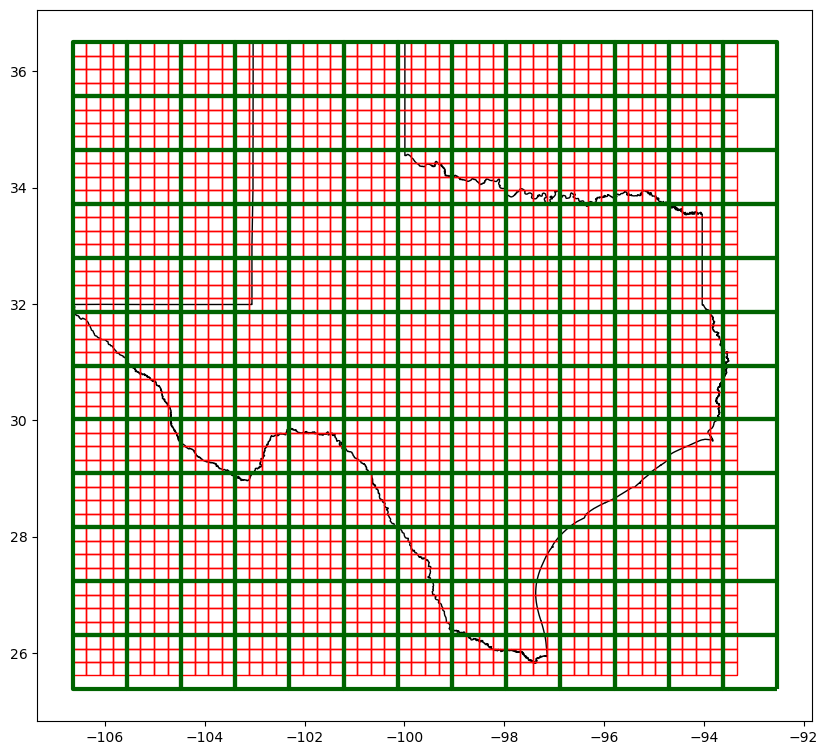

In [ ]:
fishnet_creator_example.plot_fishnet()

## Filtering

We can filter the `Fishnet` to one specific region to avoid working on the whole area, simply to increase computational speed.

In [ ]:
region = [-95.799944,29.374853,-95.028636,29.795492]

# Filter the fishnet by the larger bounding box
fishnet_creator_example.filter_fishnet_by_bbox(region)
fishnet_creator_example.filtered_fishnet.head(5)

,id,geometry,batch_id
1411,1411,"POLYGON ((-95.78689 29.78485, -95.78689 30.016...",100
1412,1412,"POLYGON ((-95.51541 29.78485, -95.51541 30.016...",101
1413,1413,"POLYGON ((-95.24393 29.78485, -95.24393 30.016...",101
1414,1414,"POLYGON ((-94.97244 29.78485, -94.97244 30.016...",101
1460,1460,"POLYGON ((-95.78689 29.55328, -95.78689 29.784...",100


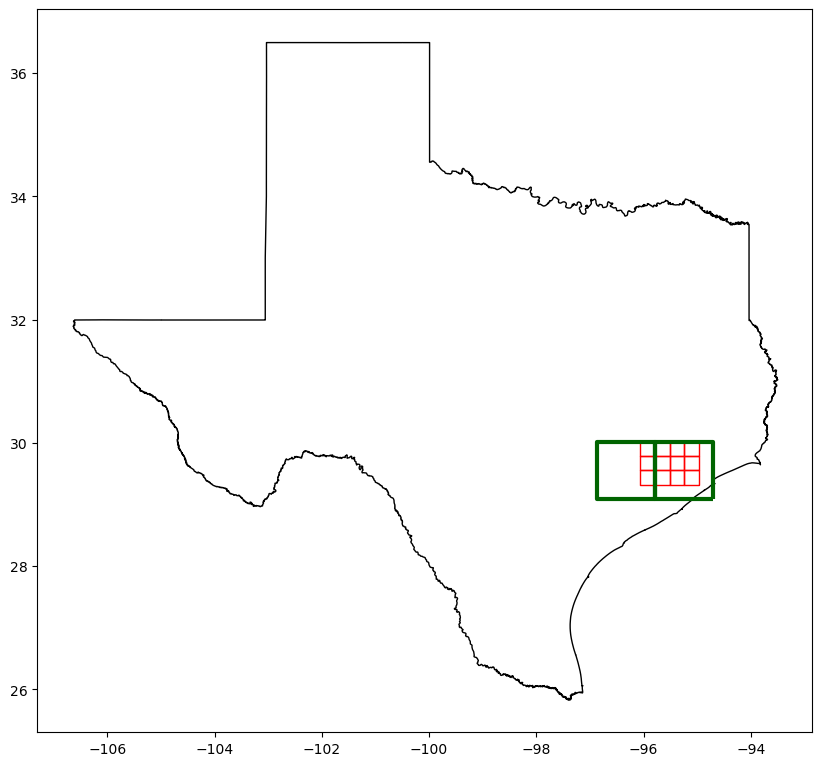

In [ ]:
fishnet_creator_example.plot_filtered_fishnet()

## Save and load the fishnet object

In [ ]:
# this specific fishnet was 0.25miles granular and 4miles edge of each batch.
fishnet_creator_example.save('../Gis/Fishnet/fishnet_quarter_mile.pkl') 

# load the object
fishnet_creator_example = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile.pkl')

# Export Images from the Google Earth Engine

In [ ]:
# Create an instance of the Fishnet class
fishnet_creator = Fishnet('/content/drive/MyDrive/Code/Gis/Texas_State_Boundary/State.shp', 0.25, overlay_method='union', clip=False)

# Create the fishnet
fishnet_creator.create_fishnet()

lon:  0.004241936610313246 lat:  0.0036182855831654592


100%|██████████| 2948/2948 [05:50<00:00,  8.42it/s]


Generating polygons...
Success. Fishnet created.


,id,geometry
0,0,"POLYGON ((-106.64199 36.49677, -106.64199 36.5..."
1,1,"POLYGON ((-106.63775 36.49677, -106.63775 36.5..."
2,2,"POLYGON ((-106.63350 36.49677, -106.63350 36.5..."
3,3,"POLYGON ((-106.62926 36.49677, -106.62926 36.5..."
4,4,"POLYGON ((-106.62502 36.49677, -106.62502 36.5..."
...,...,...
9132899,9132899,"POLYGON ((-93.52168 25.83368, -93.52168 25.837..."
9132900,9132900,"POLYGON ((-93.51744 25.83368, -93.51744 25.837..."
9132901,9132901,"POLYGON ((-93.51319 25.83368, -93.51319 25.837..."
9132902,9132902,"POLYGON ((-93.50895 25.83368, -93.50895 25.837..."


In [ ]:
fishnet_creator.batch(4)

100%|██████████| 185/185 [00:01<00:00, 144.92it/s]


In [ ]:
# Filter the fishnet (the one loaded is unfiltered)
region = [-95.799944,29.374853,-95.028636,29.795492]
fishnet_creator.filter_fishnet_by_bbox(region)

In [ ]:
image_exporter = ImageExporter(fishnet_creator, filtered=True)

image_exporter.set_date_range(2022)

image_exporter.set_folder('DW_landcover')

image_exporter.export_images()

# Process Images

In [ ]:
img_process = ImageProcessor(fishnet_creator, '/content/drive/MyDrive/DW_landcover', "landcover_batchID", filtered=True)

In [ ]:
img_process.process_images()

Processing Images:: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


In [ ]:
fishnet_creator.filtered_fishnet.head()

,id,geometry,batch_id,ImageCoordinates,MeanPixel
5743150,5743150.0,"POLYGON ((-95.79960 29.79208, -95.79960 29.795...",22469.0,"(567, 524, 615, 564)",229.367188
5743151,5743151.0,"POLYGON ((-95.79536 29.79208, -95.79536 29.795...",22469.0,"(615, 524, 662, 564)",245.912234
5743152,5743152.0,"POLYGON ((-95.79111 29.79208, -95.79111 29.795...",22469.0,"(662, 524, 709, 564)",141.877660
5743153,5743153.0,"POLYGON ((-95.78687 29.79208, -95.78687 29.795...",22469.0,"(709, 524, 757, 564)",230.031250
5743154,5743154.0,"POLYGON ((-95.78263 29.79208, -95.78263 29.795...",22470.0,"(0, 524, 47, 564)",177.007979


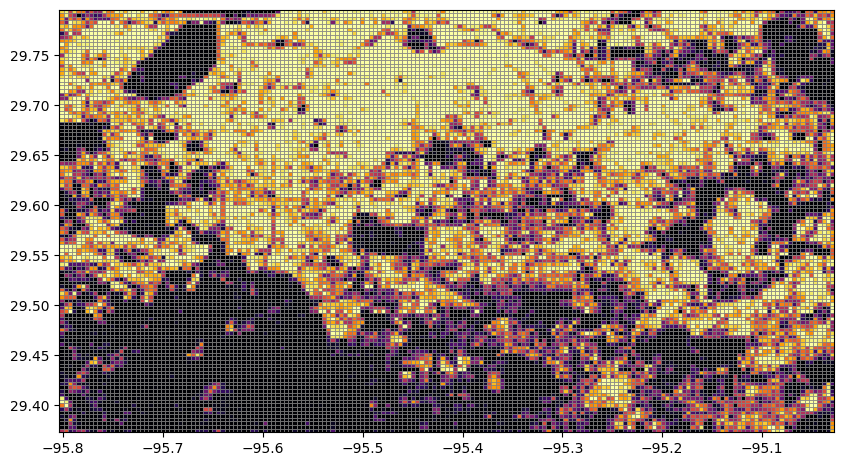

In [ ]:
fishnet_creator.plot_heatmap(filtered=True)

In [ ]:
fishnet_creator.save('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_2022.pkl')

# Compute difference between two fishnets

In [10]:
# load NEW fishnet
fishnet_creator_new = Fishnet.load('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_2022.pkl')
filtered_fishnet_new = fishnet_creator_new.filtered_fishnet

# load OLD fishnet
fishnet_creator_old = Fishnet.load('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_2016.pkl')
filtered_fishnet_old = fishnet_creator_old.filtered_fishnet

# rename
filtered_fishnet_new.rename({'MeanPixel': 'MeanPixelNew'}, axis=1, inplace = True)
filtered_fishnet_old.rename({'MeanPixel': 'MeanPixelOld'}, axis=1, inplace = True)

# merge
fishnet_difference = filtered_fishnet_old.merge(filtered_fishnet_new, on = ["id", "geometry", "batch_id", "ImageCoordinates"])

# compute difference
fishnet_difference["MeanPixel"] = fishnet_difference["MeanPixelNew"] - fishnet_difference["MeanPixelOld"]

# create new instance and set filtered_fishnet as the difference
from copy import deepcopy
fishnet_creator_difference = deepcopy(fishnet_creator)
fishnet_creator_difference.filtered_fishnet = fishnet_difference

# plot the difference
fishnet_creator_difference.plot_heatmap(filtered=True)


ModuleNotFoundError: ignored